Техническая задача: сделать модуль сравнения тем 1 к 1 с оригинальными, разные расстояния + визуализация. 

In [60]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')

import distances_helper as dh 
import print_helper as ph
import create_model_helper as cmh
import build_convex_hull_helper as bchh
import different_models as dm

from plot_helper import PlotMaker
from config_helper import ConfigPaths
from scipy.optimize import minimize
from scipy.optimize import linear_sum_assignment
    

0.8.1


In [52]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_05_03_100_topics\models.txt


In [53]:
def create_model_100_fn_1(n_iteration):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100 + n_iteration,
                             n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name='model_100_m1_iter_{}'.format(n_iteration))
    return tmp_model

def create_model_100_fn_2(n_iteration):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100 + n_iteration,
                            n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name='model_100_m1_iter_{}'.format(n_iteration))
    return tmp_model

In [54]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def save_model_pickle(_model_name, _model, _save=True):
    phi = _model.get_phi()
    phi = phi[(phi.T != 0).any()]
    theta = _model.get_theta()    
    saved_top_tokens = _model.score_tracker['top_tokens_score'].last_tokens
    if _save:
        save_pickle_file(phi, 'phi_{}.p'.format(_model_name))
        save_pickle_file(theta, 'theta_{}.p'.format(_model_name))
        save_pickle_file(saved_top_tokens, 'saved_top_tokens_{}.p'.format(_model_name))
    return phi, theta, saved_top_tokens
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def load_model_pickle(_model_name, _distance_name=None, _path=config.experiment_path):
    phi = load_pickle_file('phi_{}.p'.format(_model_name), _path)
    theta = load_pickle_file('theta_{}.p'.format(_model_name), _path)
    saved_top_tokens = load_pickle_file('saved_top_tokens_{}.p'.format(_model_name), _path)
    distances = None
    if _distance_name is not None:
        distances = load_pickle_file('{}.p'.format(_distance_name), _path)
    return phi, theta, saved_top_tokens, distances

Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [55]:
phi_original, theta_original, saved_top_tokens_original, distances_hellinger_model_original = load_model_pickle('model3', 'distances_hellinger_model3', config.output_batches_path)
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


Запустить несколько раз с разным рандомом. Следить за тем, чтобы накапливались только независимые темы. Каждый раз смотреть. как проектируется на оригинальную матрицу.

In [56]:
# now some info from run
# distibution of topics in convex hull by iteration
def plot_convex_hull_topics_iterations_distribution(_phi_convex_hull):
    get_iteration_number_fn = lambda x: int(x[x.find('_', 6) + 1 : ])
    phi_convex_hull_iteration_number = [get_iteration_number_fn(col) for col in _phi_convex_hull.columns]
    phi_convex_hull_iteration_number = [(val, phi_convex_hull_iteration_number.count(val), 1.0 * phi_convex_hull_iteration_number.count(val) / len(phi_convex_hull_iteration_number)) for val in set(phi_convex_hull_iteration_number)]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[1] for x in phi_convex_hull_iteration_number], ax=ax1)
    ax1.set_title('Number of topics from each iteration')
    ax1.set_xlabel('n iteration')

    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[2] for x in phi_convex_hull_iteration_number], ax=ax2)
    ax2.set_title('Number of topics from each iteration (%)')
    ax2.set_xlabel('n iteration')
def plot_convex_hull_columns_change(iterations_info):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    ax1.plot([sum([val['n_topics_to_remove']for val in it['iterations_info_filter']]) for it in iterations_info], 
             color='r', label = 'total')
    ax1.set_title('Num columns to remove')
    get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
    get_topic_filter_iteration_list_fn = lambda x, y: [get_topic_iteration_fn(topic) for topic in x].count(y)
    n_topics_removed_from_current_iteration = [sum([get_topic_filter_iteration_list_fn(val['removed_topics'], indx) for val in it['iterations_info_filter']]) for indx, it in enumerate(iterations_info)]
    ax1.plot(n_topics_removed_from_current_iteration, color='b', label='current iteration')
    ax1.set_xlabel('n iteration')
    ax1.legend()

    ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r')
    ax2.set_title('Num columns of convex hull')
    ax2.set_xlabel('n iteration')
    ax2.legend()
def plot_opt_res_fun(iterations_filtering_info_name):
    %matplotlib inline
    iterations_filtering_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_filtering_info for val in item for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item for x in val['opt_res'].values()] for item in iterations_filtering_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def plot_opt_res_fun_filtering(iterations_filtering_info_name):
    iterations_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_info for val in item['iterations_info_filter'] for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item['iterations_info_filter'] for x in val['opt_res'].values()] for item in iterations_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)

# granularity

In [57]:
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, global_th=0.95):
    cur_sum, sum_count = 0, 0
    for val in col.sort_values()[::-1]:
        if cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=5*1e-2)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    title = '{} {} \nx_count_grans_mean = {}; th={}'.format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean
def get_distances(phi_original, name):
    phi_convex_hull = load_pickle_file(name)
    distances_to_original = bchh.calculate_distances(dh.hellinger_dist, phi_convex_hull, phi_original)
    inter_distances = bchh.calculate_distances(dh.hellinger_dist, phi_convex_hull, phi_convex_hull)
    opt_res_to_original = bchh.get_optimization_result(dh.hellinger_dist, None, phi_convex_hull, phi_original,
                                                       distances_to_original, n_closest_topics=N_CLOSEST_TOPICS)
    save_pickle_file(distances_to_original, 'distances_to_original__' + name)
    save_pickle_file(inter_distances, 'inter_distances__' + name)
    save_pickle_file(opt_res_to_original, 'opt_res_to_original__' + name)
    return phi_convex_hull, distances_to_original, inter_distances, opt_res_to_original
def load_distances(name):
    phi_convex_hull = load_pickle_file(name)
    distances_to_original = load_pickle_file('distances_to_original__' + name)
    inter_distances = load_pickle_file('inter_distances__' + name)
    opt_res_to_original = load_pickle_file('opt_res_to_original__' + name)
    return phi_convex_hull, distances_to_original, inter_distances, opt_res_to_original
# построим распределение полученных distances
def plot_dists(distances_to_original, inter_distances, opt_res_to_original, name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    vals = distances_to_original.values.flatten()
    sns.distplot(vals[vals != 0], color='r', ax = ax1, label='Inter distances')
    vals = inter_distances.values.flatten()
    sns.distplot(vals[vals != 0],  color='b', ax = ax1, label='Distances to original')
    ax1.set_title("distances  " + name)
    ax1.legend()
    sns.distplot([val.fun for val in opt_res_to_original.itervalues()], color='r', bins=10, ax=ax2)
    ax2.set_title("opts  " + name)
    ax2.legend()

# task1
Найти модель (1 итерация filter ch), которая
* будет иметь гранулярность близкую к original (=55)
* будет иметь opt_res_mean - через 1

In [58]:
models_count = 20
names_list, phi_convex_hull_list =  [0] * models_count,  [0] * models_count
iterations_info_list, iterations_filtering_list =  [0] * models_count, [0] * models_count
distances_to_original_list, opt_res_to_original_list, opt_original_to_res_list = [0] * models_count, [0] * models_count, [0] * models_count

In [59]:
idx = 0

get_result_one_matrix_fn = bchh.get_optimization_result_one_matrix
OPT_FUN_THRESHOLD, N_CLOSEST_TOPICS_COUNT, DIST_FN  = 0.6, 15, dh.hellinger_dist
names_list[idx] = 'hellinger__wf__model_100_m1__0.6__15_r1'
phi_convex_hull_list[idx], iterations_info_list[idx], iterations_filtering_list[idx] = bchh \
                                                    .build_convex_hull_with_filtering(
                                                     create_model_100_fn_1,
                                                     bchh.get_topics_to_remove_by_opt_fun_and_distance, 
                                                     DIST_FN,
                                                     get_result_one_matrix_fn,
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     n_closest_topics_count=N_CLOSEST_TOPICS_COUNT,
                                                     opt_fun_threshold=OPT_FUN_THRESHOLD,
                                                     use_previous_iterations=True,
                                                     max_iteration=1)
%matplotlib inline
distances_to_original_list[idx] = bchh.calculate_distances(DIST_FN, phi_convex_hull_list[idx], phi_original)
# opt_res_to_original_list[idx] = bchh.get_optimization_result(DIST_FN, None, phi_convex_hull_list[idx], phi_original,
#                                                    distances_to_original_list[idx], n_closest_topics=N_CLOSEST_TOPICS_COUNT)
# opt_original_to_res_list[idx] = bchh.get_optimization_result(DIST_FN, None, phi_original,  phi_convex_hull_list[idx],
#                                                    distances_to_original_list[idx].T, n_closest_topics=N_CLOSEST_TOPICS_COUNT)

# _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_res_to_original_list[idx], names_list[idx])
# _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_original_to_res_list[idx], names_list[idx])

[2017-03-07 21:21:07.239000] ********** iteration = 1 / 1
name = model_100_m1_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25

[2017-03-07 21:24:00.763000] filtering iteration = 1 / 50
[2017-03-07 21:25:18.376000] 4 topics to remove, 7 not_removed_topics_count because close topics, current convex_hull shape = (2216, 96)
[2017-03-07 21:25:18.378000] filtering iteration = 2 / 50
[2017-03-07 21:26:13.640000] 1 topics to remove, 4 not_removed_topics_count because close topics, current convex_hull shape = (2216, 95)
[2017-03-07 21:26:13.640000] filtering iteration = 3 / 50
[2017-03-07 21:26:44.666000] 1 topics to remove, 2 not_removed_topics_count because close topics, current convex_hull shape = (2216, 94)
[2017-03-07 21:26:44.682000] filtering iteration = 4 / 50
[2017-03-07 21:27:25.238000] 1 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 93)
[2017-03-07 2

In [79]:
distance = distances_to_original_list[idx]

In [160]:
jac_cost = bchh.calculate_distances(dh.kl_dist, phi_convex_hull_list[idx], phi_original)

In [11]:
distance = jac_cost

In [12]:
cost = distance

In [123]:
def get_cost_matrix(original_distance, not_original_column_fine_right, not_test_column_fine_down, new_new_fine_corner=1e-5):
    default_empty_value = 100
    # без этого не работает - разобраться
    distance = original_distance.copy()
    distance[distance > not_original_column_fine_right] = default_empty_value
    test_columns_count, original_columns_count =  distance.shape
    right_matrix = pd.DataFrame(np.identity(test_columns_count) * not_original_column_fine_right, index = distance.index)
    down_matrix = pd.DataFrame(np.identity(original_columns_count) * not_test_column_fine_down, columns = distance.columns)
    corner_matrix = pd.DataFrame(new_new_fine_corner, index = down_matrix.index, columns = right_matrix.columns)
    expanded_down_matrix = pd.concat([down_matrix, corner_matrix], axis=1)
    expanded_matrix =  pd.concat([distance, right_matrix], axis=1)
    expanded_matrix =  pd.concat([expanded_matrix, expanded_down_matrix], axis=0)
    expanded_matrix[expanded_matrix == 0] = default_empty_value
    return expanded_matrix
def indices_to_result(cost_matrix_not_expanded, row_ind, col_ind):
    test_columns_count, original_columns_count =  cost_matrix_not_expanded.shape
    indices = zip(row_ind, col_ind)
    indices = [val for val in indices if val[0] < test_columns_count and val[1] < original_columns_count]
    indices = [(cost_matrix_not_expanded.index[val[0]], cost_matrix_not_expanded.columns[val[1]],
                val[0], val[1], cost_matrix_not_expanded.iloc[val[0], val[1]]) for val in indices]
    return indices
def get_hungarian_alg_result(cost_matrix, fine):
    expanded_cost = get_cost_matrix(cost_matrix, fine, fine, new_new_fine_corner=1e-5)
    row_ind, col_ind = linear_sum_assignment(expanded_cost)
    res = indices_to_result(cost_matrix, row_ind, col_ind)
    return res, expanded_cost, row_ind, col_ind
def get_test_to_original_result(phi_test, phi_original, dist_fn, thresholds=np.arange(0.05, 1, 0.05)):
    cost = bchh.calculate_distances(dist_fn, phi_test, phi_original)
    results = {}
    for th in thresholds:
        res, expanded_cost, row_ind, col_ind = get_hungarian_alg_result(cost, th)
        dynamic_print('Processed th = {}, original columns count = {}'.format(th, len(res)))
        results[th] = res
    return results

In [122]:
from sys import stdout
from time import sleep
def dynamic_print(data):
    sys.stdout.write("\r\x1b[K"+data.__str__())
    sys.stdout.flush()

In [145]:
different_distances = {}
distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
for dist_fn in distances:
    results = get_test_to_original_result(phi_convex_hull_list[idx], phi_original, dist_fn)
    threshold_and_original_columns_count = sorted([(key, len(results[key])) for key in results.iterkeys()])
    different_distances[dist_fn] = (threshold_and_original_columns_count, results)

Processed th = 0.95, original columns count = 03

In [170]:
def plot_original_columns_count_different_distances(different_distances):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))

    threshold_and_original_columns_count = different_distances[dh.jaccard_dist][0]
    x,y = zip(*threshold_and_original_columns_count)
    ax1.plot(x, y, 'ro-', label='jaccard')

    threshold_and_original_columns_count = different_distances[dh.cos_dist][0]
    x,y = zip(*threshold_and_original_columns_count)
    ax1.plot(x, y, 'bo-', label='cos')

    ax1.plot([0, 1], [phi_original.shape[1], phi_original.shape[1]], linewidth=2, color='g', linestyle='--')

    ax1.set_xlabel('thresholds')
    ax1.set_ylabel('original shape count')
    ax1.legend()


    threshold_and_original_columns_count = different_distances[dh.hellinger_dist][0]
    x,y = zip(*threshold_and_original_columns_count)
    ax2.plot(x, y, 'yo-', label='hellinger')

    threshold_and_original_columns_count = different_distances[dh.kl_dist][0]
    x,y = zip(*threshold_and_original_columns_count)
    ax2.plot(x, y, 'bo-', label='kl')

    threshold_and_original_columns_count = different_distances[dh.kl_sym_dist][0]
    x,y = zip(*threshold_and_original_columns_count)
    ax2.plot(x, y, 'mo-', label='kl sym')

    ax2.plot([0, 1], [phi_original.shape[1], phi_original.shape[1]], linewidth=2, color='g', linestyle='--')

    ax2.set_xlabel('thresholds')
    ax2.set_ylabel('original shape count')
    ax2.legend()

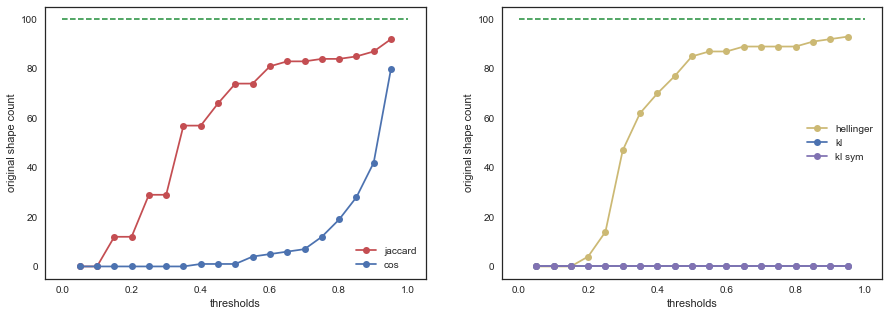

In [171]:
plot_original_columns_count_different_distances(different_distances)

In [151]:
test_mat = pd.DataFrame([[0.1, 0.2, 0.8], [0.8, 0.7, 0.2]])
res = get_hungarian_alg_result(test_mat, 0.5)
for val in res:
    print val
print "______________"
res = get_hungarian_alg_result(test_mat, 0.1)
for val in res:
    print val

[(0, 0, 0, 0, 0.10000000000000001), (1, 2, 1, 2, 0.20000000000000001)]
       0      1      2          0          1
0    0.1    0.2  100.0    0.50000  100.00000
1  100.0  100.0    0.2  100.00000    0.50000
0    0.5  100.0  100.0    0.00001    0.00001
1  100.0    0.5  100.0    0.00001    0.00001
2  100.0  100.0    0.5    0.00001    0.00001
[0 1 2 3 4]
[0 2 4 1 3]
______________
[(0, 0, 0, 0, 0.10000000000000001)]
       0      1      2          0          1
0    0.1  100.0  100.0    0.10000  100.00000
1  100.0  100.0  100.0  100.00000    0.10000
0    0.1  100.0  100.0    0.00001    0.00001
1  100.0    0.1  100.0    0.00001    0.00001
2  100.0  100.0    0.1    0.00001    0.00001
[0 1 2 3 4]
[0 4 3 1 2]


In [50]:
row_ind, col_ind = linear_sum_assignment(jac_cost)
for ind in range(len(row_ind)):
    print jac_cost.iloc[row_ind[ind], col_ind[ind]]
    print ' '.join(phi_convex_hull_list[idx].iloc[:, row_ind[ind]].sort_values()[::-1][0:N_CLOSEST_TOPICS_COUNT].index)
    print ' '.join(phi_original.iloc[:, col_ind[ind]].sort_values()[::-1][0:N_CLOSEST_TOPICS_COUNT].index)
    print '---------------------------'

0.333333333333
тело самец птица самка микроорганизм сигнал шимпанзе примат вид рыба группа динозавр боль еврей здоровье
тело самец самка птица микроорганизм шимпанзе сигнал примат рыба динозавр группа вид болото размер вода
---------------------------
0.333333333333
система задача компьютер программа математика область проблема число работа подход простой образ сложность алгоритм помощь
система задача компьютер программа математика область алгоритм сложность проблема математик подход число схема вычисление работа
---------------------------
0.333333333333
вариант раса целое лицо идеал человечество справедливость признак предприятие идея комиссия акцент достижение тип изменчивость
вариант раса идеал справедливость предприятие комиссия акцент лицо человечество целое изменчивость роберт признак высокий_образование античность
---------------------------
0.421052631579
нейрон связь автомобиль стимул феномен момент активность работник работа блок процесс область выполнение синапс изменение
н

In [44]:
cost.shape, phi_convex_hull_list[idx].shape

((93, 100), (2216, 93))